In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from operator import attrgetter
from platform import python_version_tuple

xrange = range

import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from extract_data import *
from skimage.transform import resize
from dual_IDG import DualImageDataGenerator


In [ ]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'a')

### Exploring data

In [ ]:
h5py.__version__

In [ ]:
X_train, disc_train, cup_train, file_codes_train = extract_DRISHTI_GS_train(os.path.join(os.path.dirname(os.getcwd()), 'data', 'Drishti-GS'))
print(len(X_train), X_train[0].shape, len(disc_train), disc_train[0].shape, len(cup_train), cup_train[0].shape, len(file_codes_train))

In [ ]:
plt.imshow(X_train[49])

#### DRISHTI-GS (train)

In [ ]:
resolution = get_resolution_DRISHTI_GS()
str_dt = h5py.special_dtype(vlen=str)

### Resizing Training Data

In [ ]:
resolutions = (512, 256, 128)

for res in resolutions:
    h5f.create_group("DRISHTI-GS/{} px".format(res))

In [41]:
db = 'DRISHTI-GS'
X_ds =  np.array(X_train)
disc_ds = np.array(disc_train)
cup_ds = np.array(cup_train)
file_codes_ds = np.array(file_codes_train)

NameError: name 'X_train' is not defined

In [ ]:
for res in resolutions:
    print('Copying data for {}, resolution {}'.format(db, res))
    X_small_ds = h5f.create_dataset("{}/{} px/images".format(db, res), 
                                    (X_ds.shape[0], res, res, 3,), 
                                    chunks=(2, res, res, 3,), 
                                    dtype=X_ds.dtype, compression="gzip")
    disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                       (X_ds.shape[0], res, res, 1,),  
                                       chunks=(2, res, res, 1,), 
                                       dtype=X_ds.dtype, compression="gzip")
    cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds.dtype, compression="gzip")
    str_dt = h5py.special_dtype(vlen=str_dt)
    file_codes_small_ds = h5f.create_dataset("{}/{} px/file_codes".format(db, res), 
                                             (X_ds.shape[0],),  
                                             chunks=True, 
                                             dtype=str_dt, compression="gzip")

    for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
        X_small_ds[i,:,:,:] = resize(X_ds[i], (res, res)) 
        
        cur_disc_small = resize(disc_ds[i][..., 0], (res, res))
        disc_small_ds[i,:,:] = cur_disc_small[..., np.newaxis]
        
        cur_cup_small =  resize(cup_ds[i][..., 0], (res, res))
        cup_small_ds[i] = cur_cup_small[..., np.newaxis]

In [26]:
h5f1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'a')
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS_128.hdf5'), 'a')

In [14]:


X = h5f1["DRISHTI-GS/512 px/images"]
d = h5f1["DRISHTI-GS/512 px/disc"]
c = h5f1["DRISHTI-GS/512 px/cup"]
disc_locations = h5f1['DRISHTI-GS/512 px/disc_locations']
resize_to=128

train_idx = np.arange(0, 50)
test_idx  = np.arange(0, 51)

idx = train_idx[:100]

img_resized = []
cup_resized = []
disc_resized = []

db = 'DRISHTI-GS'
res = 128

X_small_ds = h5f.create_dataset("{}/{} px/img".format(db, res), 
                                (X.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X.dtype, compression="gzip")
disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                   (X.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=d.dtype, compression="gzip")
cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                              (X.shape[0], res, res, 1,),  
                              chunks=(2, res, res, 1,), 
                              dtype=c.dtype, compression="gzip")

#for i in tqdm_notebook(xrange(X.shape[0]), leave = True):
batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
batch_X = [np.rollaxis(img, 2) for img in batch_X]

batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
           for img in batch_X]
batch_X = np.array(batch_X).copy()


batch_y = [d[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_y = [img[..., 0] for img in batch_y]
batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
batch_y = np.array(batch_y).copy()


batch_z = [c[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_z = [img[..., 0] for img in batch_z]
batch_z = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_z]
batch_z = np.array(batch_z).copy()

for i in tqdm_notebook(xrange(X.shape[0]), leave = True):    
    X_small_ds[i] = batch_X[i]
    disc_small_ds[i] = batch_z[i]
    cup_small_ds[i] = batch_y[i]


<ipython-input-14-53135caef631>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X.shape[0]), leave = True):


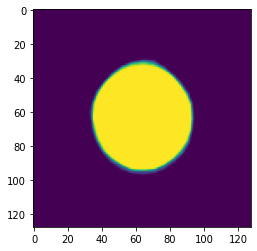

In [15]:
plt.imshow(h5f['DRISHTI-GS/128 px/cup'][0])
plt.show()

In [16]:
#h5f['DRISHTI-GS/128 px/img'] = img_resized
#h5f['DRISHTI-GS/128 px/cup'] = cup_resized
#h5f['DRISHTI-GS/128 px/disc'] = disc_resized

In [17]:
disc_locations = h5f1['DRISHTI-GS/512 px/disc_locations_20']
X = h5f1["DRISHTI-GS/512 px/images"]

idx = train_idx[:100]

img_resized = []
cup_resized = []
disc_resized = []

db = 'DRISHTI-GS'
res = 128

X_small_ds = h5f.create_dataset("{}/{} px/img-20".format(db, res), 
                                (X.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X.dtype, compression="gzip")
disc_small_ds = h5f.create_dataset("{}/{} px/disc-20".format(db, res), 
                                   (X.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=X.dtype, compression="gzip")
cup_small_ds = h5f.create_dataset("{}/{} px/cup-20".format(db, res), 
                              (X.shape[0], res, res, 1,),  
                              chunks=(2, res, res, 1,), 
                              dtype=X.dtype, compression="gzip")

#for i in tqdm_notebook(xrange(X_ds.shape[0]), leave = True):
batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
batch_X = [np.rollaxis(img, 2) for img in batch_X]

batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
           for img in batch_X]
batch_X = np.array(batch_X).copy()


batch_y = [d[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_y = [img[..., 0] for img in batch_y]
batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
batch_y = np.array(batch_y).copy()


batch_z = [c[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_z = [img[..., 0] for img in batch_z]
batch_z = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_z]
batch_z = np.array(batch_z).copy()

for i in tqdm_notebook(xrange(X.shape[0]), leave = True):    
    X_small_ds[i] = batch_X[i]
    disc_small_ds[i] = batch_z[i]
    cup_small_ds[i] = batch_y[i]
    

<ipython-input-17-4e9ebead497d>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X.shape[0]), leave = True):


In [33]:
#h5f['DRISHTI-GS/128 px/img-20'] = img_resized
#h5f['DRISHTI-GS/128 px/cup-20'] = cup_resized
#h5f['DRISHTI-GS/128 px/disc-20'] = disc_resized

In [18]:

X = h5f1["DRISHTI-GS-test/512 px/images"]
d = h5f1["DRISHTI-GS-test/512 px/disc"]
c = h5f1["DRISHTI-GS-test/512 px/cup"]
disc_locations = h5f1['DRISHTI-GS-test/512 px/disc_locations']

idx = test_idx[:100]

img_resized = []
cup_resized = []
disc_resized = []

db = 'DRISHTI-GS-test'
res = 128

X_small_ds = h5f.create_dataset("{}/{} px/img".format(db, res), 
                                (X.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X.dtype, compression="gzip")
disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                   (X.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=X.dtype, compression="gzip")
cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                              (X.shape[0], res, res, 1,),  
                              chunks=(2, res, res, 1,), 
                              dtype=X.dtype, compression="gzip")

#for i in tqdm_notebook(xrange(X.shape[0]), leave = True):
batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
batch_X = [np.rollaxis(img, 2) for img in batch_X]

batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
           for img in batch_X]
batch_X = np.array(batch_X).copy()


batch_y = [d[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_y = [img[..., 0] for img in batch_y]
batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
batch_y = np.array(batch_y).copy()


batch_z = [c[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_z = [img[..., 0] for img in batch_z]
batch_z = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_z]
batch_z = np.array(batch_z).copy()

for i in tqdm_notebook(xrange(X.shape[0]), leave = True):    
    X_small_ds[i] = batch_X[i]
    disc_small_ds[i] = batch_z[i]
    cup_small_ds[i] = batch_y[i]


<ipython-input-18-c3822390df8f>:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X.shape[0]), leave = True):


In [19]:
#h5f['DRISHTI-GS-test/128 px/img'] = img_resized
#h5f['DRISHTI-GS-test/128 px/cup'] = cup_resized
#h5f['DRISHTI-GS-test/128 px/disc'] = disc_resized

In [21]:
disc_locations = h5f1['DRISHTI-GS-test/512 px/disc_locations_20']
X = h5f1["DRISHTI-GS-test/512 px/images"]

idx = test_idx[:100]

img_resized = []
cup_resized = []
disc_resized = []

db = 'DRISHTI-GS-test'
res = 128

X_small_ds = h5f.create_dataset("{}/{} px/img-20".format(db, res), 
                                (X.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X.dtype, compression="gzip")
disc_small_ds = h5f.create_dataset("{}/{} px/disc-20".format(db, res), 
                                   (X.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=X.dtype, compression="gzip")
cup_small_ds = h5f.create_dataset("{}/{} px/cup-20".format(db, res), 
                              (X.shape[0], res, res, 1,),  
                              chunks=(2, res, res, 1,), 
                              dtype=X.dtype, compression="gzip")

#for i in tqdm_notebook(xrange(X.shape[0]), leave = True):
batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
batch_X = [np.rollaxis(img, 2) for img in batch_X]

batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
           for img in batch_X]
batch_X = np.array(batch_X).copy()


batch_y = [d[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_y = [img[..., 0] for img in batch_y]
batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
batch_y = np.array(batch_y).copy()


batch_z = [c[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
           for i in idx]
batch_z = [img[..., 0] for img in batch_z]
batch_z = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_z]
batch_z = np.array(batch_z).copy()

for i in tqdm_notebook(xrange(X.shape[0]), leave = True):    
    X_small_ds[i] = batch_X[i]
    disc_small_ds[i] = batch_z[i]
    cup_small_ds[i] = batch_y[i]

<ipython-input-21-7fa76c1940f7>:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X.shape[0]), leave = True):


In [22]:
#h5f['DRISHTI-GS-test/128 px/img-20'] = img_resized
#h5f['DRISHTI-GS-test/128 px/cup-20'] = cup_resized
#h5f['DRISHTI-GS-test/128 px/disc-20'] = disc_resized

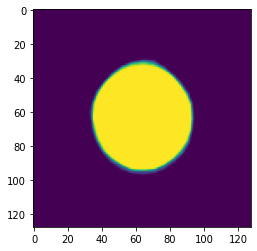

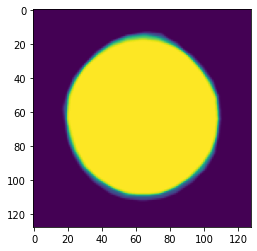

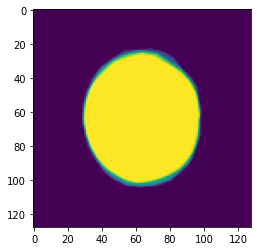

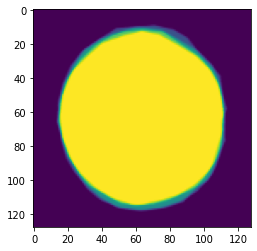

In [27]:
plt.imshow(h5f['DRISHTI-GS/128 px/cup'][0])
plt.show()
plt.imshow(h5f['DRISHTI-GS/128 px/cup-20'][0])
plt.show()
plt.imshow(h5f['DRISHTI-GS-test/128 px/cup'][0])
plt.show()
plt.imshow(h5f['DRISHTI-GS-test/128 px/cup-20'][0])
plt.show()

In [25]:
h5f.close()
h5f1.close()

In [ ]:
gap = 50
standard_res = (512, 512)
X_ds = h5f["DRISHTI-GS/512 px/images"]
disc_ds = h5f["DRISHTI-GS/512 px/disc"]
cup_ds = h5f["DRISHTI-GS/512 px/cup"]

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_cropped = []
cup_cropped = []
disc_cropped = []

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds[i, ..., 0]
    cup = cup_ds[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)

    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
        
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)
    
    img_cropped.append(img_cur_cropped)
    cup_cropped.append(cup_cur_cropped)
    disc_cropped.append(disc_cur_cropped)

h5f['DRISHTI-GS/512 px/disc_locations'] = disc_locations
h5f['DRISHTI-GS/512 px/img_cropped'] = img_cropped
h5f['DRISHTI-GS/512 px/cup_cropped'] = cup_cropped
h5f['DRISHTI-GS/512 px/disc_cropped'] = disc_cropped

In [ ]:
gap = 20
disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_cropped = []
cup_cropped = []
disc_cropped = []

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds[i, ..., 0]
    cup = cup_ds[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)

    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
        
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)
    
    img_cropped.append(img_cur_cropped)
    cup_cropped.append(cup_cur_cropped)
    disc_cropped.append(disc_cur_cropped)

h5f['DRISHTI-GS/512 px/disc_locations_20'] = disc_locations
h5f['DRISHTI-GS/512 px/img_cropped_20'] = img_cropped
h5f['DRISHTI-GS/512 px/cup_cropped_20'] = cup_cropped
h5f['DRISHTI-GS/512 px/disc_cropped_20'] = disc_cropped

In [ ]:
plt.imshow(h5f['DRISHTI-GS/512 px/img_cropped_20'][9])
plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/cup_cropped_20'][9])
plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/disc_cropped_20'][9])
plt.show()

#### DRISHTI-GS (test)

In [ ]:
X_test, disc_test, cup_test, file_codes_test = extract_DRISHTI_GS_test(os.path.join(os.path.dirname(os.getcwd()), 'data', 'Drishti-GS'))
print(len(X_test), X_test[0].shape, len(disc_test), disc_test[0].shape, len(cup_test), cup_test[0].shape, len(file_codes_test))

In [ ]:
db = 'DRISHTI-GS-test'
X_ds = np.array(X_test)
cup_ds = np.array(cup_test)
disc_ds = np.array(disc_test)
file_codes_ds = np.array(file_codes_test)

for res in resolutions:
    print('Copying data for {}, resolution {}'.format(db, res))
    X_small_ds = h5f.create_dataset("{}/{} px/images".format(db, res), 
                                    (X_ds.shape[0], res, res, 3,), 
                                    chunks=(2, res, res, 3,), 
                                    dtype=X_ds.dtype, compression="gzip")
    disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=disc_ds.dtype, compression="gzip")
    cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                                      (X_ds.shape[0], res, res, 1,),  
                                      chunks=(2, res, res, 1,), 
                                      dtype=cup_ds.dtype, compression="gzip")

    str_dt = h5py.special_dtype(vlen=str)
    file_codes_small_ds = h5f.create_dataset("{}/{} px/file_codes".format(db, res), 
                                             (X_ds.shape[0],),  
                                             chunks=True, 
                                             dtype=str_dt, compression="gzip")

    for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
        X_small_ds[i] = resize(X_ds[i],(res, res))
        
        cur_disc_small = resize(disc_ds[i][..., 0], (res, res))
        disc_small_ds[i] = cur_disc_small[..., np.newaxis]  
        
        cur_cup_small = resize(cup_ds[i][..., 0], (res, res))
        cup_small_ds[i] = cur_cup_small[..., np.newaxis]
        
    file_codes_small_ds[:] = file_codes_ds[:]  

In [ ]:
X_ds = h5f["DRISHTI-GS-test/512 px/images"]
disc_ds = h5f["DRISHTI-GS-test/512 px/disc"]
cup_ds = h5f["DRISHTI-GS-test/512 px/cup"]

gap = 50
standard_res = (512, 512)

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_cropped = []
cup_cropped = []
disc_cropped = []

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds[i, ..., 0]
    cup = cup_ds[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)

    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
        
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)
    
    img_cropped.append(img_cur_cropped)
    cup_cropped.append(cup_cur_cropped)
    disc_cropped.append(disc_cur_cropped)

h5f['DRISHTI-GS-test/512 px/disc_locations'] = disc_locations
h5f['DRISHTI-GS-test/512 px/img_cropped'] = img_cropped
h5f['DRISHTI-GS-test/512 px/cup_cropped'] = cup_cropped
h5f['DRISHTI-GS-test/512 px/disc_cropped'] = disc_cropped

In [ ]:
X_ds = h5f["DRISHTI-GS-test/512 px/images"]
disc_ds = h5f["DRISHTI-GS-test/512 px/disc"]
cup_ds = h5f["DRISHTI-GS-test/512 px/cup"]

gap = 20
standard_res = (512, 512)

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_cropped = []
cup_cropped = []
disc_cropped = []

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds[i, ..., 0]
    cup = cup_ds[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)

    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
        
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)
    
    img_cropped.append(img_cur_cropped)
    cup_cropped.append(cup_cur_cropped)
    disc_cropped.append(disc_cur_cropped)

h5f['DRISHTI-GS-test/512 px/disc_locations_20'] = disc_locations
h5f['DRISHTI-GS-test/512 px/img_cropped_20'] = img_cropped
h5f['DRISHTI-GS-test/512 px/cup_cropped_20'] = cup_cropped
h5f['DRISHTI-GS-test/512 px/disc_cropped_20'] = disc_cropped

In [ ]:
plt.imshow(h5f['DRISHTI-GS-test/512 px/img_cropped_20'][9])
plt.show()
plt.imshow(h5f['DRISHTI-GS-test/512 px/cup_cropped_20'][9])
plt.show()
plt.imshow(h5f['DRISHTI-GS-test/512 px/disc_cropped_20'][9])
plt.show()

In [51]:
h5f.close()
h5f1.close()